In [1]:
from basic_utils import *
import datetime

On cuda:0
Figure directory exists.


In [2]:
class MultiCity_Cycle_Dataset(Dataset):
    def __init__(self):
        
        train_set = set()
        self.img_train_PM25, self.img_test_PM25 = [], []
        self.PM25, self.PM25_train, self.PM25_test = [], [], []
        
        self.train, self.test = [], []
        
        holdout = ['Shadipur', 'North_Campus', 'R_K_Puram', 'Sector116', 'Sirifort', 'Patparganj', 'CRRI_MTR_Rd', 'Sector125', 
               'Major_Dhyan_Chand_National_Stadium', 'Aya_Nagar', 'NSIT_Dwarka', 'Sri_Aurobindo_Marg', 'Bawana', 'Loni', 
               'Sector1', 'Narela', 'Dwarka_Sector_8', 'Mundka', 'Sanjay_Nagar', 'ITO', 'Jahangirpuri', 'Alipur', 'Ashok_Vihar', 
               'Sonia_Vihar', 'New_Collectorate', 'Okhla_Phase2', 'Pusa_IMD']

        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_clean.pkl', "rb") as fp:  
            images = pkl.load(fp)
            for data_point in tqdm(images, position=0, leave=True): 
                self.PM25.append(data_point['PM25'])

                if data_point['Station_index'] not in holdout:
                    train_set.add(data_point['Station_index'])
            train_set = sorted(list(train_set))

            for data_point in images:
                if data_point['Station_index'] in train_set:
                    self.train.append(tuple((data_point['Image'], data_point['PM25'])))

                elif data_point['Station_index'] in holdout:
                    self.test.append(tuple((data_point['Image'], data_point['PM25'])))
            
        #Only adding to training
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:  
            images = pkl.load(fp)
            for data_point in tqdm(images):
                for station in data_point:
                    self.train.append(tuple((station['Image'][:,:,:3], station['PM'])))
                        
                    
#         with open('/datacommons/carlsonlab/srs108/old/ol/Mumbai.pkl', "rb") as fp:
#             images = pkl.load(fp)
#             for data_point in tqdm(images):
#                 for station in data_point:
#                     self.train.append(tuple((station['Image'][:,:,:3], station['PM'])))
        
        self.test = random.choices(self.test, k=len(self.train))

        
    def __len__(self): return len(self.train)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            

        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
#                             transforms.RandomRotation(degrees=30),
                            transforms.CenterCrop(size=224),
                            transforms.Pad(16),
                            transforms.ToTensor()])

        source_img = self.train[idx][0]
        source_PM = self.train[idx][1]
        source_img = transform(source_img)

        target_img = self.test[idx][0]
        target_PM = self.test[idx][1]             
        target_img = transform(target_img)

        sample = {
        'source img': source_img,
        'source pm' : source_PM,
        'target img': target_img,
        'target_PM' : target_PM} #torch.tensor(self.train[idx][1])}
        return sample
       

In [3]:
x = MultiCity_Cycle_Dataset()

In [ ]:
train, val = train_test_split(x,test_size=0.2, random_state=69)

In [6]:
dataloader = DataLoader(
    train,
    batch_size=1, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=1, # 1
    shuffle=True)

In [7]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()
# criterion_PM = torch.nn.MSELoss()

In [8]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 6 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)
print()

In [9]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
        
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()
#     criterion_PM.cuda()

In [10]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)
print()

In [11]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)
optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)
# optimizer_C_A = torch.optim.Adam(
#     C_A.parameters(), lr=lr, betas=(b1, b2)
# )

In [12]:
def sample_images( dataloader, e, i, show = False, save=False):
    source = next(iter(dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = source['source img'].type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = source['target img'].type(Tensor)
    fake_A = G_BA(real_B).detach()

    recon_A = G_BA(fake_B).detach()
    recon_B = G_AB(fake_A).detach()

    real_A = make_grid(real_A, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_B = make_grid(fake_B, nrow=5, normalize=True, scale_each=True, padding=1)
    real_B = make_grid(real_B, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_A = make_grid(fake_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_A = make_grid(recon_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_B = make_grid(recon_B, nrow=5, normalize=True, scale_each=True, padding=1)
    
    # Set individual titles
    titles = [f'Real Source', f'Fake Target', f'Recon Source', f'Real Target', f'Fake Source', f'Recon Target']
    
    plt.figure(figsize=(12, 9))
    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.02, hspace=0.02)  # Adjust spacing

    for index, grid in enumerate([real_A, fake_B, recon_A, real_B, fake_A, recon_B]):
        plt.subplot(1, 6, index+1)
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title(titles[index])
        plt.axis('off')

    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    
    if show:
        plt.show()
    plt.close()


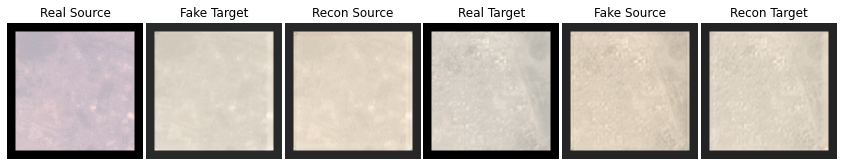

[Epoch 1/25] [Batch 5000/13233] [D loss : 0.246665] [G loss : 0.983106 - (adv : 0.257144, cycle : 0.038307, identity : 0.030270)]


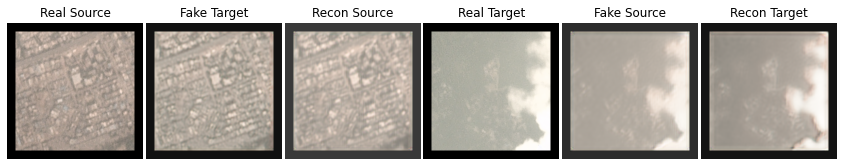

[Epoch 1/25] [Batch 10000/13233] [D loss : 0.228447] [G loss : 1.553348 - (adv : 0.400255, cycle : 0.057715, identity : 0.057475)]



NameError: name 'e' is not defined

In [13]:
history = {'epoch':[],'G_loss':[],'adv_loss': [],'cyc_loss': [], 'idt_loss': [], 'D_loss':[],'D_fake': [], 'D_real': [], 'batch':[]}
best_D_loss = 1e6
best_G_loss = 1e6
best_sem_loss = 1e7
n_epochs = 25
for epoch in range(0, n_epochs):
    for i, batch in enumerate((tqdm(dataloader))): #tqdm
        
        # Set model input
        real_A = batch['source img'].type(Tensor)
        real_B = batch['target img'].type(Tensor)
#         lbl_A = batch['source pm'].type(Tensor)
        
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        fake_A = G_BA(real_B)

        
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        recov_B = G_AB(fake_A)
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.

# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        

# ------> Total Loss
        loss_G = loss_GAN + (15.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
                
        loss_G.backward()
        optimizer_G.step()
        
# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()
    
        loss_real_A = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake_A = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_A = (loss_real_A + loss_fake_A)/2
        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()
    
        loss_real_B = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake_B = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        
        loss_D_B = (loss_real_B + loss_fake_B)/2
        loss_D_B.backward()
        optimizer_D_B.step()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
    
    
        d_real = loss_real_A + loss_real_A
        d_fake = loss_fake_B + loss_fake_B

# -----------------
# Train C_A  # forward only real source image through semantic classifier
# -----------------
#         optimizer_C_A.zero_grad()
        
#         loss_sem = criterion_PM(pm_from_real_source, lbl_A)
#         loss_sem.backward()
        
#         optimizer_C_A.step()
# -----------------
# Model Saving
# -----------------    
        if loss_D <= best_D_loss:
            best_D_loss = loss_D
            torch.save({'D_B': D_B.state_dict(), 'D_A': D_A.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/Luck_Del_Mum_Gen.pt.pt')
            
        if loss_G <= best_G_loss:
            best_G_loss = loss_G
            torch.save({ 'G_AB': G_AB.state_dict(),'G_BA': G_BA.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/Luck_Del_Mum_Disc.pt.pt')
              
        
# -----------------
# Show Progress
# -----------------
        if (i+1) % 4000 == 0:
            with torch.no_grad():
#                 sample_images('Delhi', 'Lucknow', dataloader, epoch, i, show = True, save = True)

                sample_images(val_dataloader, epoch, i, show = True, save = True)
#                 print(f'pm from real source: {pm_from_real_source.item()}\npm from fake target: {pm_from_fake_target.item()}\n\npm from real target: {pm_from_real_target.item()}\npm from fake source: {pm_from_fake_source.item()}\n')

                print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                        %(epoch+1,n_epochs,       # [Epoch -]
                          i+1,len(dataloader),   # [Batch -]
                          loss_D.item(),       # [D loss -]
                          loss_G.item(),       # [G loss -]
                          loss_GAN.item(),     # [adv -]
                          loss_cycle.item(),   # [cycle -]
#                           loss_sem.item(),     # [sem -]
                          loss_identity.item(),# [identity -]
                     ))
            
            history['G_loss'].append(loss_G.item())
            history['D_loss'].append(loss_D.item())
            history['batch'].append(i+1)
            history['epoch'].append(epoch+1)
            history['adv_loss'].append(loss_GAN.item())
            history['cyc_loss'].append(loss_cycle.item())
            history['idt_loss'].append(loss_identity.item())
            history['D_fake'].append(d_fake.item())
            history['D_real'].append(d_real.item())

    now = datetime.datetime.now()
    print(f"Epoch {epoch + 1}/{n_epochs} finished at {now.time()}")

In [ ]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)

In [ ]:
df = pd.read_csv('/datacommons/carlsonlab/srs108/cycle/phase_two/history.csv')

In [ ]:
# df

In [ ]:
# def gen_dis_loss(genloss, disloss, iters, save = True, fig_name=''):
# #     epoch = range(epochs)
#     fig, ax = plt.subplots(1,1, figsize = (6,6))   
#     ax.plot(iters, genloss, color='b', linewidth=0.5, label='Generator')
#     ax.plot(iters, disloss, color='r', linewidth=0.5, label='Discriminator')
#     ax.set_xlabel('Epochs')
#     ax.set_ylabel('Loss')
#     ax.set_title('Generator and Discriminator Loss')
#     ax.legend()
#     plt.show()
#     if save==True:
#         fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')

In [ ]:
# gen_dis_loss(df['D_fake'], df['D_real'], df['epoch'], save=True)

In [ ]:
# def trainloss(mainloss, iters, save = True, fig_name=''):
#     fig, ax = plt.subplots(1,1, figsize = (6,6))   
#     ax.plot(iters, mainloss, color='b', linewidth=0.5)
#     ax.set_xlabel('Iters')
#     ax.set_ylabel('Loss')
#     plt.show()
#     if save==True:
#         fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')
        

In [ ]:
# def gen_loss(cycloss, , iters, save = True, fig_name=''):
#     fig, ax = plt.subplots(1,1, figsize = (6,6))   
#     ax.plot(iters, mainloss, color='b', linewidth=0.5)
#     ax.set_xlabel('Iters')
#     ax.set_ylabel('Loss')
#     plt.show()
#     if save==True:
#         fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')
        

In [ ]:
# trainloss(df['idt_loss'], df['epoch'], save=False)

In [ ]:
# max(df['G_loss'])

In [ ]:
# min(df)